In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate1 as sr1
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')

**Uniform random feature experiments**

In [2]:
save_folder = f'../data/uniform-RF'
D, D_r = 3, 300
w, b = 0.4, 4
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
L0, L1 = 0.4, 3.5
percents = 50
n_repeats = 20000
n_models = percents * n_repeats
row_selection = 'uniform'
train_option = 'random_20000'
repo = '..'
L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
test = np.load('{}/test.npy'.format(L63_data_folder))
limits_W_in, limits_W = [-0.1, 0.1], [-.5, .5]

batch = sr1.BatchStrategy_SMLR(save_folder, D, D_r, n_repeats, beta, error_threshold, train, test[:1], dt, Lyapunov_time, L0, L1, percents,\
                          row_selection, train_option, limits_W_in, limits_W)
batch.run_uniform(w, b, save_data=True)
bsa = sr1.BatchStrategyAnalyzer_SMLR(batch.save_folder)
# bsa.compute_train_loss(train)
# bsa.compute_test_loss_single(test)

Running experiments ...
Working on batch 0 ...
Documenting results ...
Time taken for batch of experiments = 11.57s
Working on batch 1 ...


KeyboardInterrupt: 

**Histogram of phi**

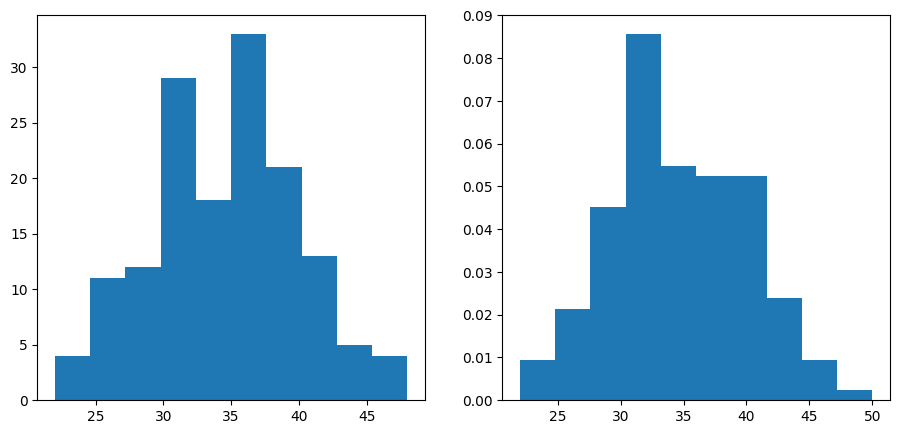

In [112]:
n = 1000
data = bsa.get_data()
phi_b, phi_g = [], []
threshold = 0.998
index_b, nature_b = data[data['tau_f_se'] < 0.5]['l'].to_numpy().astype(int), 'bad'
test_path = test[0,:, :1]
tau_f_b = []
tau_f_g = []

for i in index_b[:150]:
    model = bsa.get_model(i)
    f = np.abs(np.tanh(model.W_in @ test_path + model.b_in[:, np.newaxis]))
    phi_b.append((f < 0.9).sum())
    tau_f_b.append(data['tau_f_se'][i])

index_g, nature_g = data[data['tau_f_se'] > 6]['l'].to_numpy().astype(int), 'good' 
for i in index_g[:150]:
    model = bsa.get_model(i)
    f = np.abs(np.tanh(model.W_in @ test_path + model.b_in[:, np.newaxis]))
    phi_g.append((f < 0.9).sum())
    tau_f_g.append(data['tau_f_se'][i])

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
# ax.hist(phi_g, density=0)
# ax.hist(phi_b, density=0, alpha=0.7)
# ax.set_xlim(-0.1, 0)
# ax1.set_xlim(-0.1, 0)
ax.hist(phi_b)
ax1.hist(phi_g, density=1)
plt.show()

In [2]:
save_folder = '../data/bad-features-grid'
D, D_r = 3, 300
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
w_max, b_max = 0.4, 4.0
sqrt_n_models = 30
n_repeats = 10

L63_data_folder = '../data/L63-trajectories'
train = np.load('{}/train.npy'.format(L63_data_folder))
validation = np.load('{}/validation.npy'.format(L63_data_folder))[:, :800]
batch = sr.BatchUniform_SMLR(save_folder, D, D_r, w_max, b_max, sqrt_n_models, beta, error_threshold, dt, Lyapunov_time)
# batch.run(train[:, :20000], n_repeats)

In [3]:
bsa = sr.BatchRunAnalyzer_SMLR(save_folder)
# bsa.compute_error(validation, rmse_threshold=np.sqrt(0.05))
bsa.count(validation, limits_in=[-0.1, 0.1], limits=[-0.5, 0.5], threshold=3.5)

Time taken by count is 131.0797 seconds


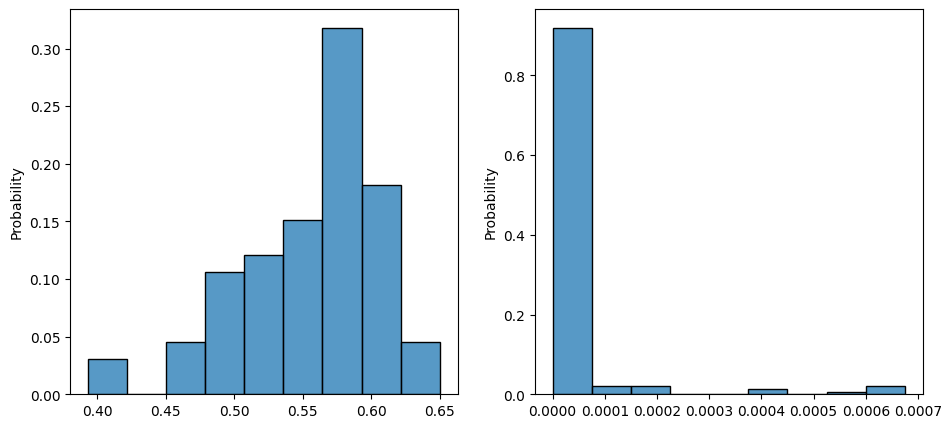

In [25]:
n = 1000
data = bsa.get_data()
phi_b, phi_g = [], []
threshold = 0.998
d = data[data['tau_f_se'] < 0.5]
index_b, nature_b = list(zip(list(d['i'].to_numpy().astype(int)), list(d['j'].to_numpy().astype(int)), list(d['k'].to_numpy().astype(int)))), 'bad'
test_path = validation
tau_f_b = []
tau_f_g = []

for i, j, k in index_b:
    phi_b.append(data[data['i']==i][data['j']==j][data['k']==k]['avg_bad_features'].to_numpy()[0]/D_r)
    tau_f_b.append(data['tau_f_se'][i])

d = data[data['tau_f_se'] > 6]
index_g, nature_g = list(zip(list(d['i'].to_numpy().astype(int)), list(d['j'].to_numpy().astype(int)), list(d['k'].to_numpy().astype(int)))), 'good' 
for i, j, k in index_g[:150]:
    phi_g.append(data[data['i']==i][data['j']==j][data['k']==k]['avg_bad_features'].to_numpy()[0]/D_r)

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
# ax.hist(phi_g, density=0)
# ax.hist(phi_b, density=0, alpha=0.7)
# ax.set_xlim(-0.1, 0)
# ax1.set_xlim(-0.1, 0)
sns.histplot(phi_b, ax=ax, stat='probability')
sns.histplot(phi_g, ax=ax1, stat='probability')
plt.show()

In [12]:
phi_b

[118.0475,
 117.90125,
 144.5925,
 148.97875,
 140.485,
 141.50625,
 141.29,
 149.76125,
 159.21375,
 153.58125,
 150.62375,
 150.24625,
 147.2275,
 155.66,
 151.085,
 159.05625,
 153.86875,
 163.6675,
 175.2825,
 165.65625,
 172.04625,
 156.8975,
 159.39375,
 160.68875,
 168.1,
 167.60375,
 167.43,
 161.31375,
 178.6675,
 183.33375,
 166.7175,
 175.83875,
 175.525,
 175.42375,
 163.1975,
 165.495,
 173.98,
 175.22125,
 173.31625,
 175.795,
 172.7825,
 181.98375,
 177.16,
 179.6975,
 175.62875,
 171.775,
 195.04375,
 173.795,
 185.4475,
 186.8975,
 178.1725,
 174.80625,
 169.4875,
 172.63375,
 167.8075,
 173.2125,
 179.7,
 178.8525,
 184.495,
 176.55375,
 184.75625,
 176.74625,
 194.1925,
 178.37375,
 175.6025,
 184.44125]